In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import requests
from io import BytesIO




In [2]:
q = '''
SELECT target_uid,
       count(DISTINCT UID)
FROM bun_log_db.raw_buntalk
WHERE YEAR||MONTH||DAY = '20201012'
GROUP BY 1
''';
buntalk = pd.read_sql(q, con=bun_dw)

In [3]:
buntalk.columns = ['content_owner', 'buntalk_uid_cnt']
buntalk['content_owner'] = buntalk['content_owner'].astype(str)
buntalk.head()

,content_owner,buntalk_uid_cnt
0,5864067,4
1,8718631,1
2,3146085,1
3,12384458,2
4,9054058,8


In [4]:
imp_df = pd.read_csv('imp_df_2.csv')

/Users/emilyPark/.pyenv/versions/bun-analytics/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
ad = imp_df[~imp_df['ad_type'].isna()]
no_ad = imp_df[imp_df['ad_type'].isnull()]

In [ ]:
no_ad.grouby('content_owner')['imp_cnt']

In [6]:
ad_uids = ad['content_owner'].unique()

ad_user_imp = imp_df[imp_df['content_owner'].isin(ad_uids)]
not_ad_user_imp = imp_df[~imp_df['content_owner'].isin(ad_uids)]

In [7]:
no_ad_pid_cnt = ad_user_imp[ad_user_imp['ad_type'].isna()].groupby('content_owner')['content_id'].nunique().reset_index()
ad_pid_cnt = ad_user_imp[~ad_user_imp['ad_type'].isna()].groupby('content_owner')['content_id'].nunique().reset_index()

no_ad_pid_cnt.columns = ['content_owner', 'no_ad_pid_cnt']
ad_pid_cnt.columns = ['content_owner', 'ad_pid_cnt']
no_ad_pid_cnt['content_owner'] = no_ad_pid_cnt['content_owner'].astype(str)
ad_pid_cnt['content_owner'] = ad_pid_cnt['content_owner'].astype(str)

ad_user = pd.merge(no_ad_pid_cnt, ad_pid_cnt, on = 'content_owner', how='outer')

In [8]:
total_unique = ad_user_imp.groupby('content_owner')['content_id'].nunique().reset_index()
total_unique.columns = ['content_owner', 'total_unique_pid_cnt']
total_unique['content_owner'] = total_unique['content_owner'].astype(str)
ad_user = pd.merge(ad_user, total_unique, on='content_owner', how='outer')

In [9]:
ad_imp_cnt = ad.groupby('content_owner')['imp_id'].size().reset_index()
ad_imp_cnt.columns = ['content_owner', 'imp_cnt']
ad_imp_cnt['content_owner'] = ad_imp_cnt['content_owner'].astype(str)
ad_user = pd.merge(ad_user, ad_imp_cnt, on='content_owner')

Text(0.5, 1.0, 'dot size scale on the number of ad used product')

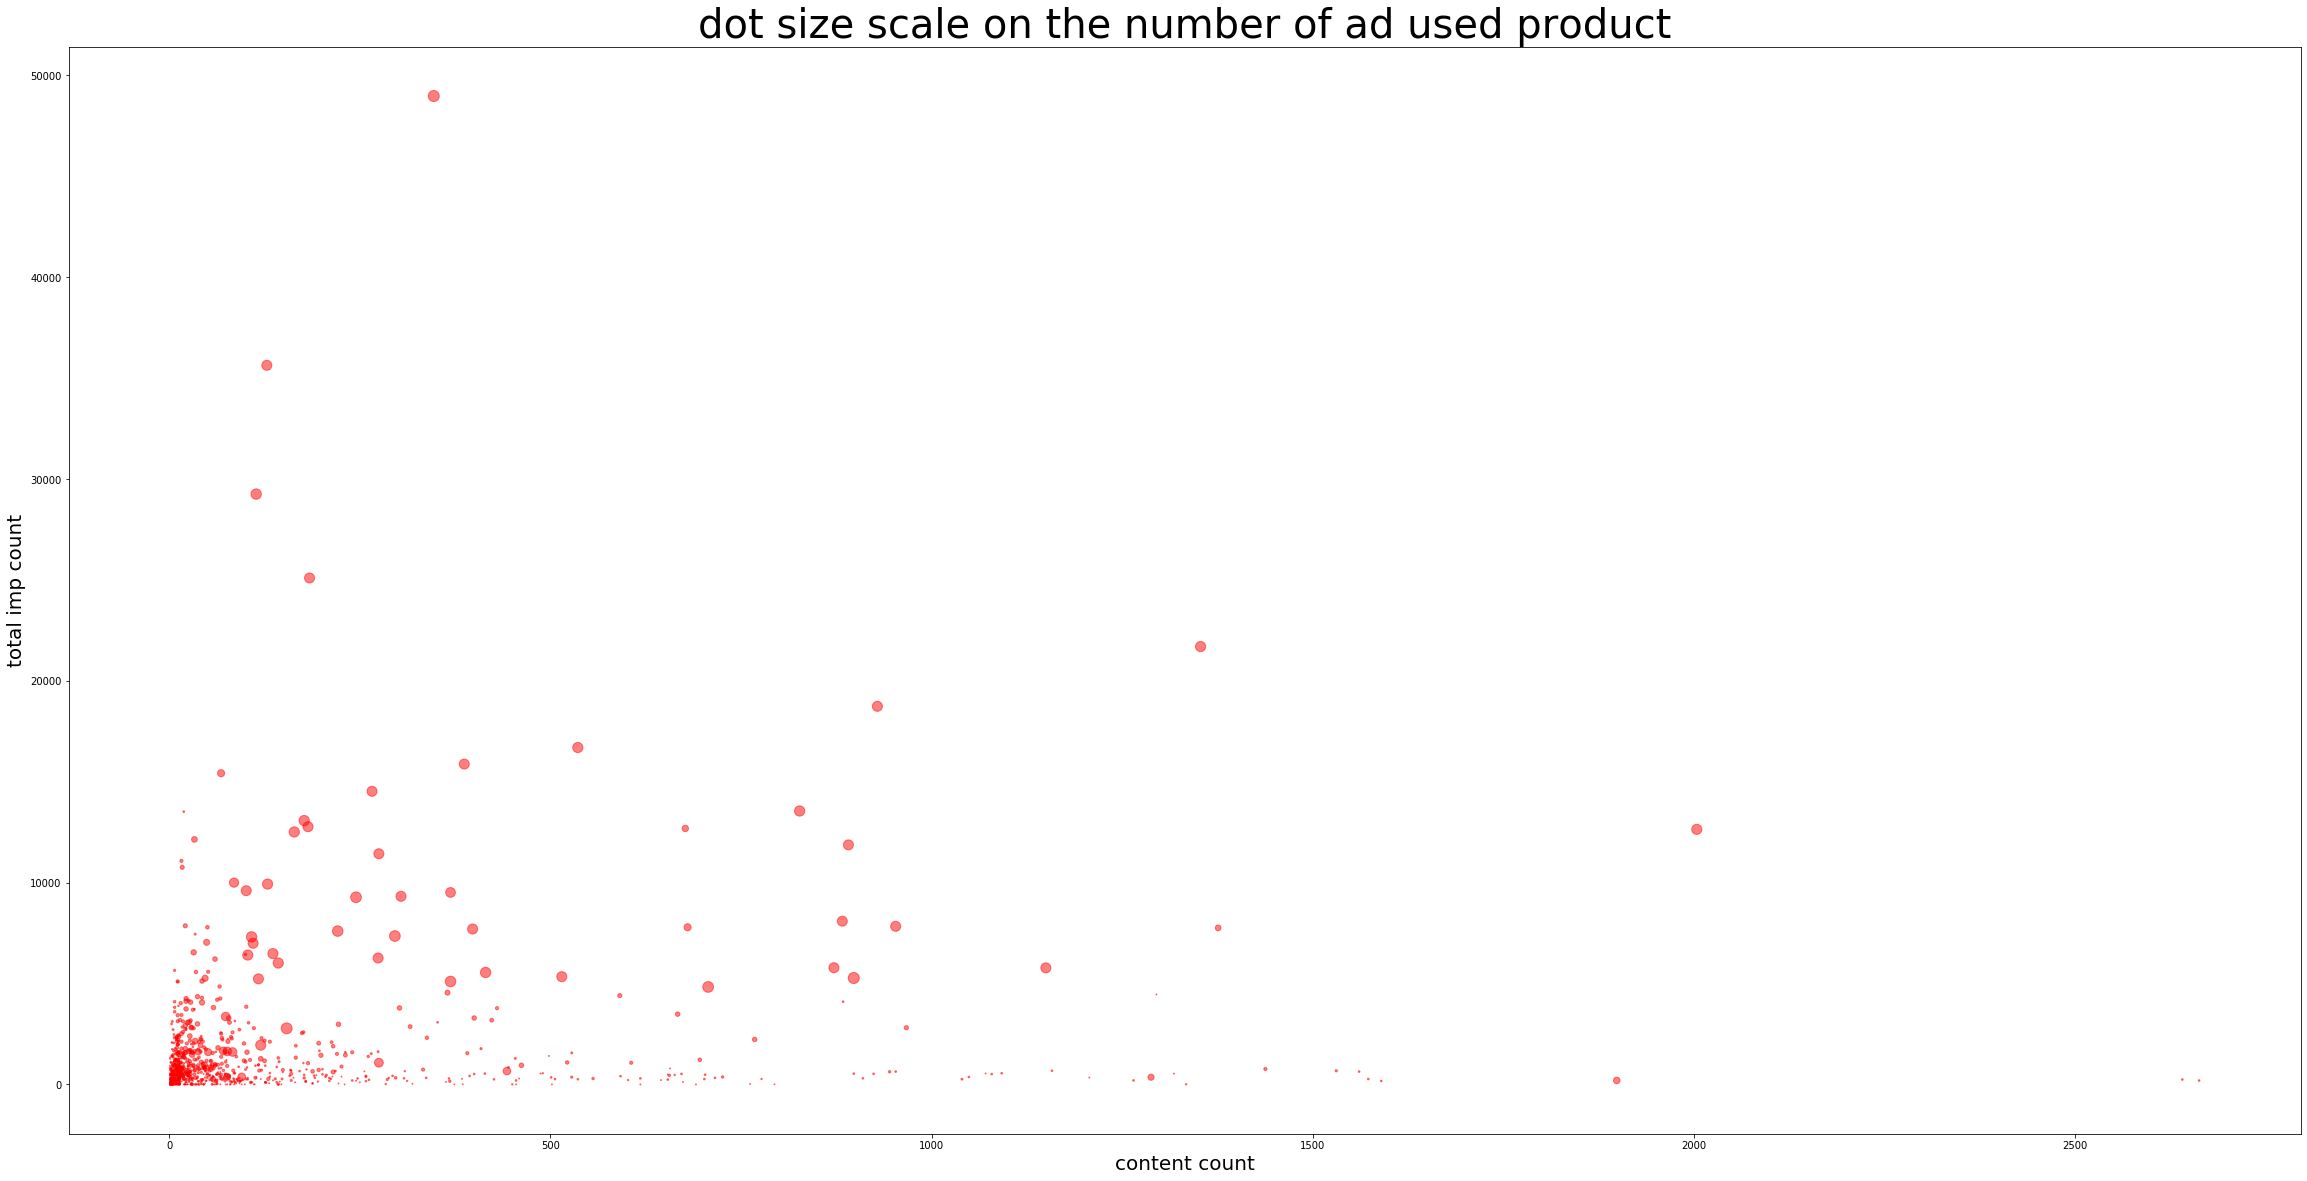

In [62]:
plt.figure(figsize=(40, 20))
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'ad_pid_cnt', alpha = 0.5, color = 'red', data=ad_user)
plt.xlabel('content count', fontsize=20)
plt.ylabel('total imp count', fontsize=20)
plt.title('dot size scale on the number of ad used product', fontsize=40)

In [75]:
ad_user.describe()

,no_ad_pid_cnt,ad_pid_cnt,total_unique_pid_cnt,imp_cnt,buntalk_uid_cnt
count,707.000000,782.000000,782.000000,782.000000,782.000000
mean,164.816124,12.141944,158.721228,1662.927110,6.597187
std,315.332820,24.018059,307.218510,3518.842894,8.719715
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,10.000000,2.000000,11.000000,250.500000,2.000000
50%,42.000000,3.000000,42.000000,643.000000,4.000000
75%,158.500000,10.000000,143.000000,1606.750000,8.000000
max,2660.000000,123.000000,2663.000000,48977.000000,80.000000


In [76]:
no_ad_user.describe()

,up_pid_cnt,no_up_pid_cnt,total_unique_pid_cnt,imp_cnt,buntalk_uid_cnt
count,11142.000000,15095.000000,26237.000000,26237.000000,26237.000000
mean,44.137318,12.870818,26.148683,309.182719,2.407440
std,141.795030,61.882617,104.784831,779.085531,2.975125
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,2.000000,2.000000,31.000000,1.000000
50%,12.000000,4.000000,6.000000,114.000000,2.000000
75%,31.000000,8.000000,15.000000,310.000000,3.000000
max,4944.000000,2638.000000,4944.000000,31326.000000,80.000000


In [14]:
no_ad_user.sort_values('imp_cnt', ascending=False)[:10000]

,content_owner,up_pid_cnt,no_up_pid_cnt,total_unique_pid_cnt,imp_cnt,buntalk_uid_cnt
9985,11682344,1334.0,NaN,1334,31326,4
10093,11804796,944.0,NaN,944,22715,4
25581,12275237,NaN,1250.0,1250,21357,1
10055,11768315,613.0,NaN,613,21233,1
8134,8751994,1657.0,NaN,1657,21092,4
10018,11730069,882.0,NaN,882,17969,2
10426,12107450,816.0,NaN,816,17022,4
16362,4263537,NaN,556.0,556,14758,9
249,224459,65.0,NaN,65,14304,11
1616,1693279,4944.0,NaN,4944,13292,2


In [10]:
up_uids = no_ad[no_ad['ifUp'] == True]['content_owner'].unique()
up_user_imp = no_ad[no_ad['content_owner'].isin(up_uids)]
no_up_user_imp = no_ad[~no_ad['content_owner'].isin(up_uids)]

In [11]:
up_pid_cnt = up_user_imp.groupby('content_owner')['content_id'].nunique().reset_index()
up_pid_cnt.columns = ['content_owner', 'up_pid_cnt']
no_up_pid_cnt = no_up_user_imp.groupby('content_owner')['content_id'].nunique().reset_index()
no_up_pid_cnt.columns = ['content_owner', 'no_up_pid_cnt']
total_unique_pid_cnt = no_ad.groupby('content_owner')['content_id'].nunique().reset_index()
total_unique_pid_cnt.columns = ['content_owner', 'total_unique_pid_cnt']
no_ad_imp_cnt = no_ad.groupby('content_owner')['imp_id'].size().reset_index()
no_ad_imp_cnt.columns = ['content_owner', 'imp_cnt']

up_pid_cnt['content_owner'] = up_pid_cnt['content_owner'].astype(str)
no_up_pid_cnt['content_owner'] = no_up_pid_cnt['content_owner'].astype(str)
total_unique_pid_cnt['content_owner'] = total_unique_pid_cnt['content_owner'].astype(str)
no_ad_imp_cnt['content_owner'] = no_ad_imp_cnt['content_owner'].astype(str)
no_ad_user = pd.merge(up_pid_cnt, no_up_pid_cnt, on = 'content_owner', how = 'outer')
no_ad_user = pd.merge(no_ad_user, total_unique_pid_cnt, on='content_owner', how='outer')
no_ad_user = pd.merge(no_ad_user, no_ad_imp_cnt, on = 'content_owner', how = 'outer')

Text(0.5, 1.0, 'dot size scale on the number of up used product')

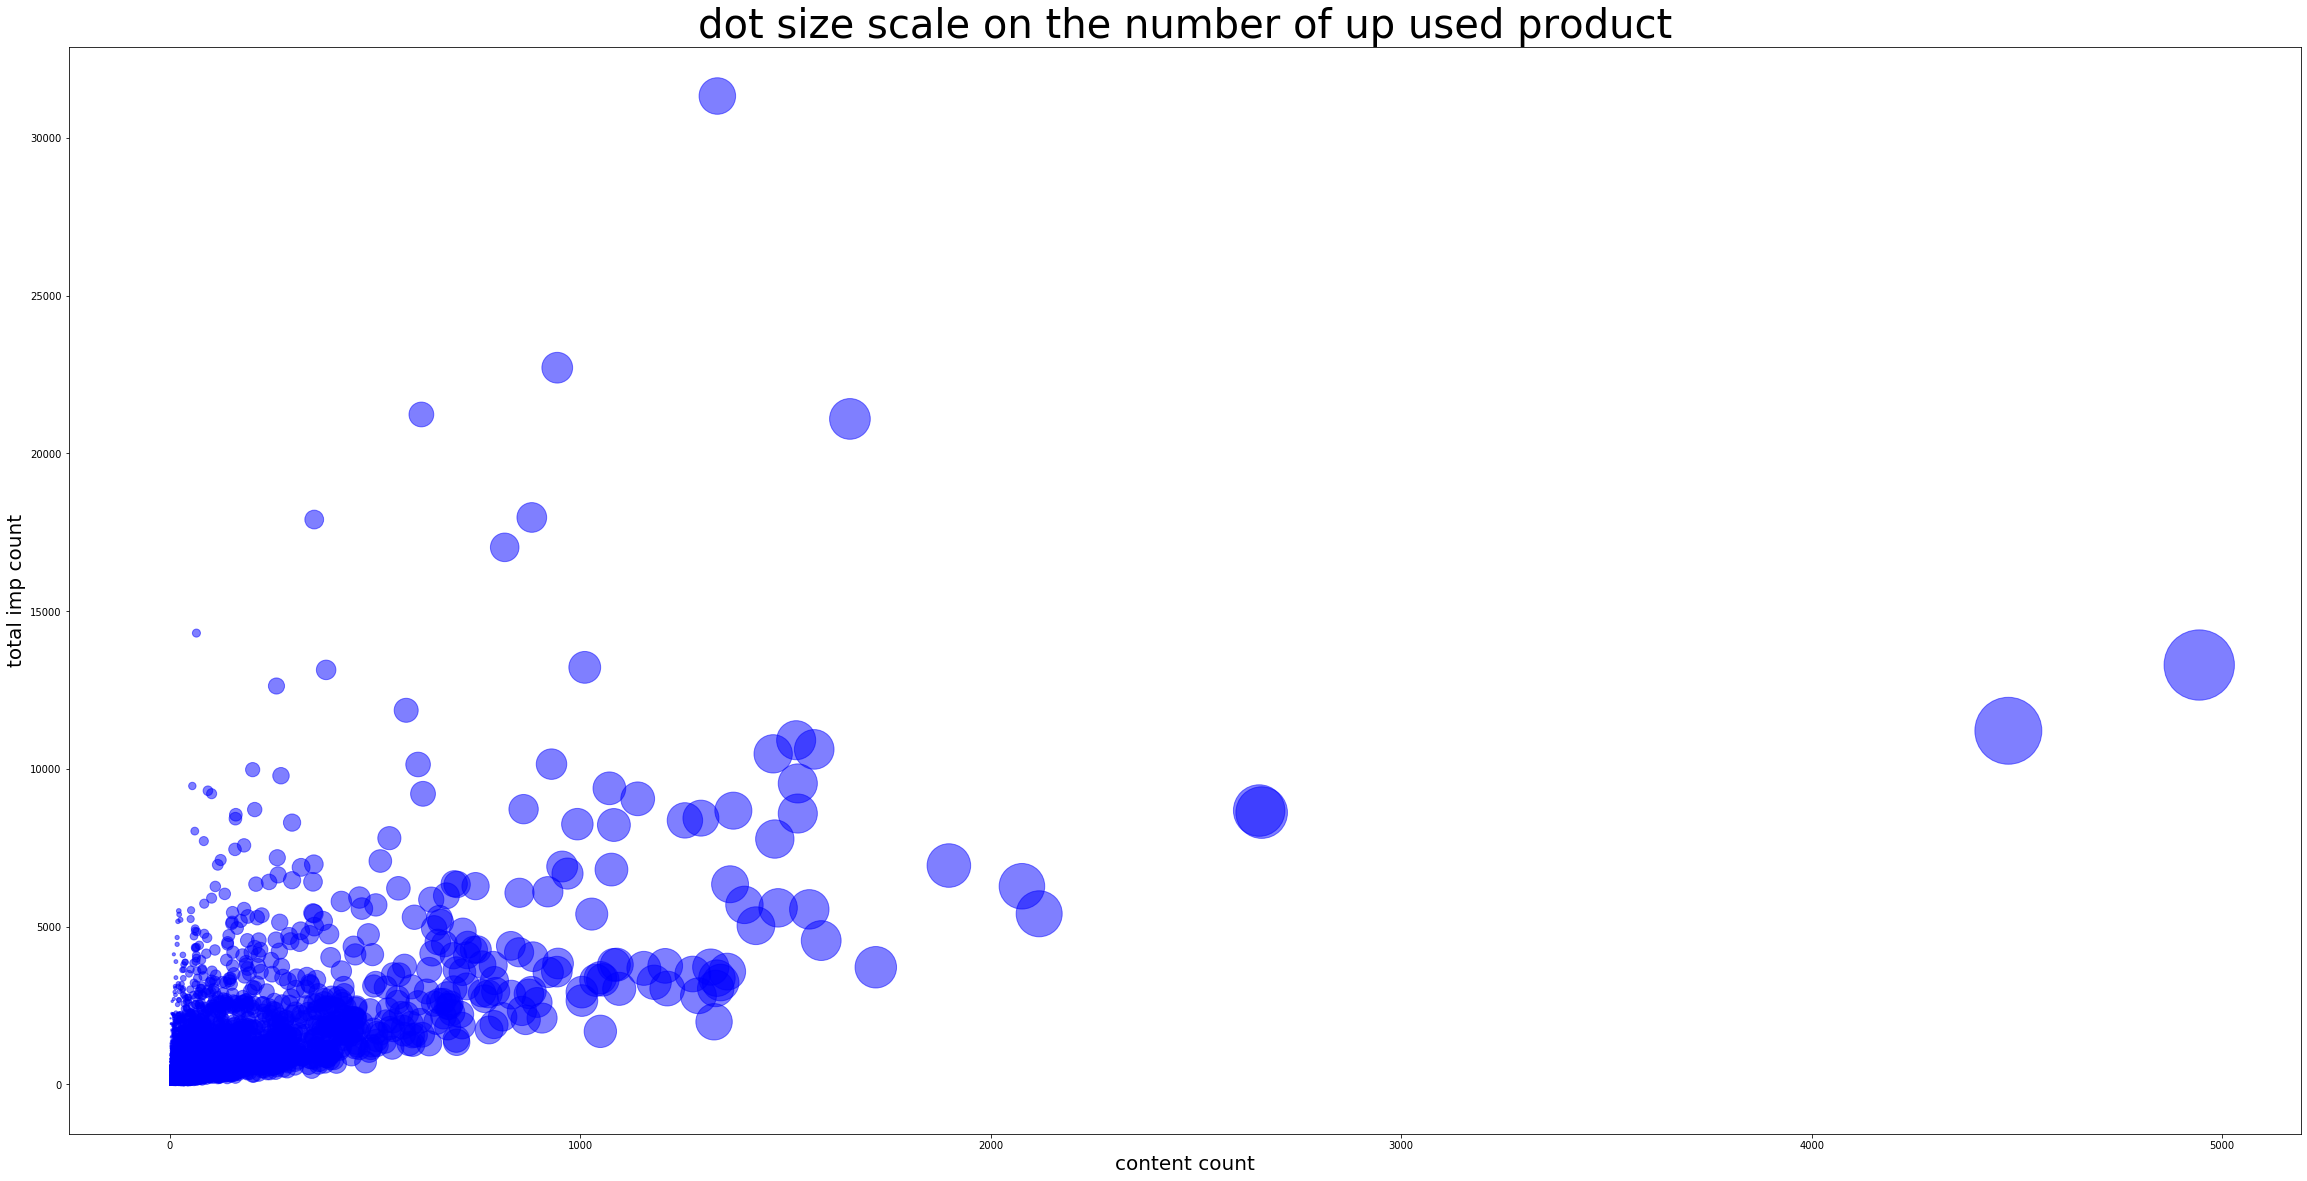

In [61]:
plt.figure(figsize=(40, 20))
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'up_pid_cnt', alpha= 0.5, color = 'blue', data=no_ad_user)
plt.xlabel('content count', fontsize=20)
plt.ylabel('total imp count', fontsize=20)
plt.title('dot size scale on the number of up used product', fontsize=40)

In [84]:
no_ad_user[no_ad_user['imp_cnt'] > 500].describe()

,up_pid_cnt,no_up_pid_cnt,total_unique_pid_cnt,imp_cnt,buntalk_uid_cnt
count,3101.000000,729.000000,3830.000000,3830.000000,3830.000000
mean,120.085456,126.989026,121.399478,1366.253525,3.836554
std,251.342315,249.279748,250.933234,1659.570050,5.076631
min,1.000000,1.000000,1.000000,501.000000,1.000000
25%,17.000000,9.000000,14.000000,625.000000,1.000000
50%,40.000000,26.000000,38.500000,838.000000,2.000000
75%,111.000000,136.000000,115.000000,1387.000000,4.000000
max,4944.000000,2638.000000,4944.000000,31326.000000,80.000000


Text(0.5, 1.0, 'dot size scale on the number of SA AD/UP used product')

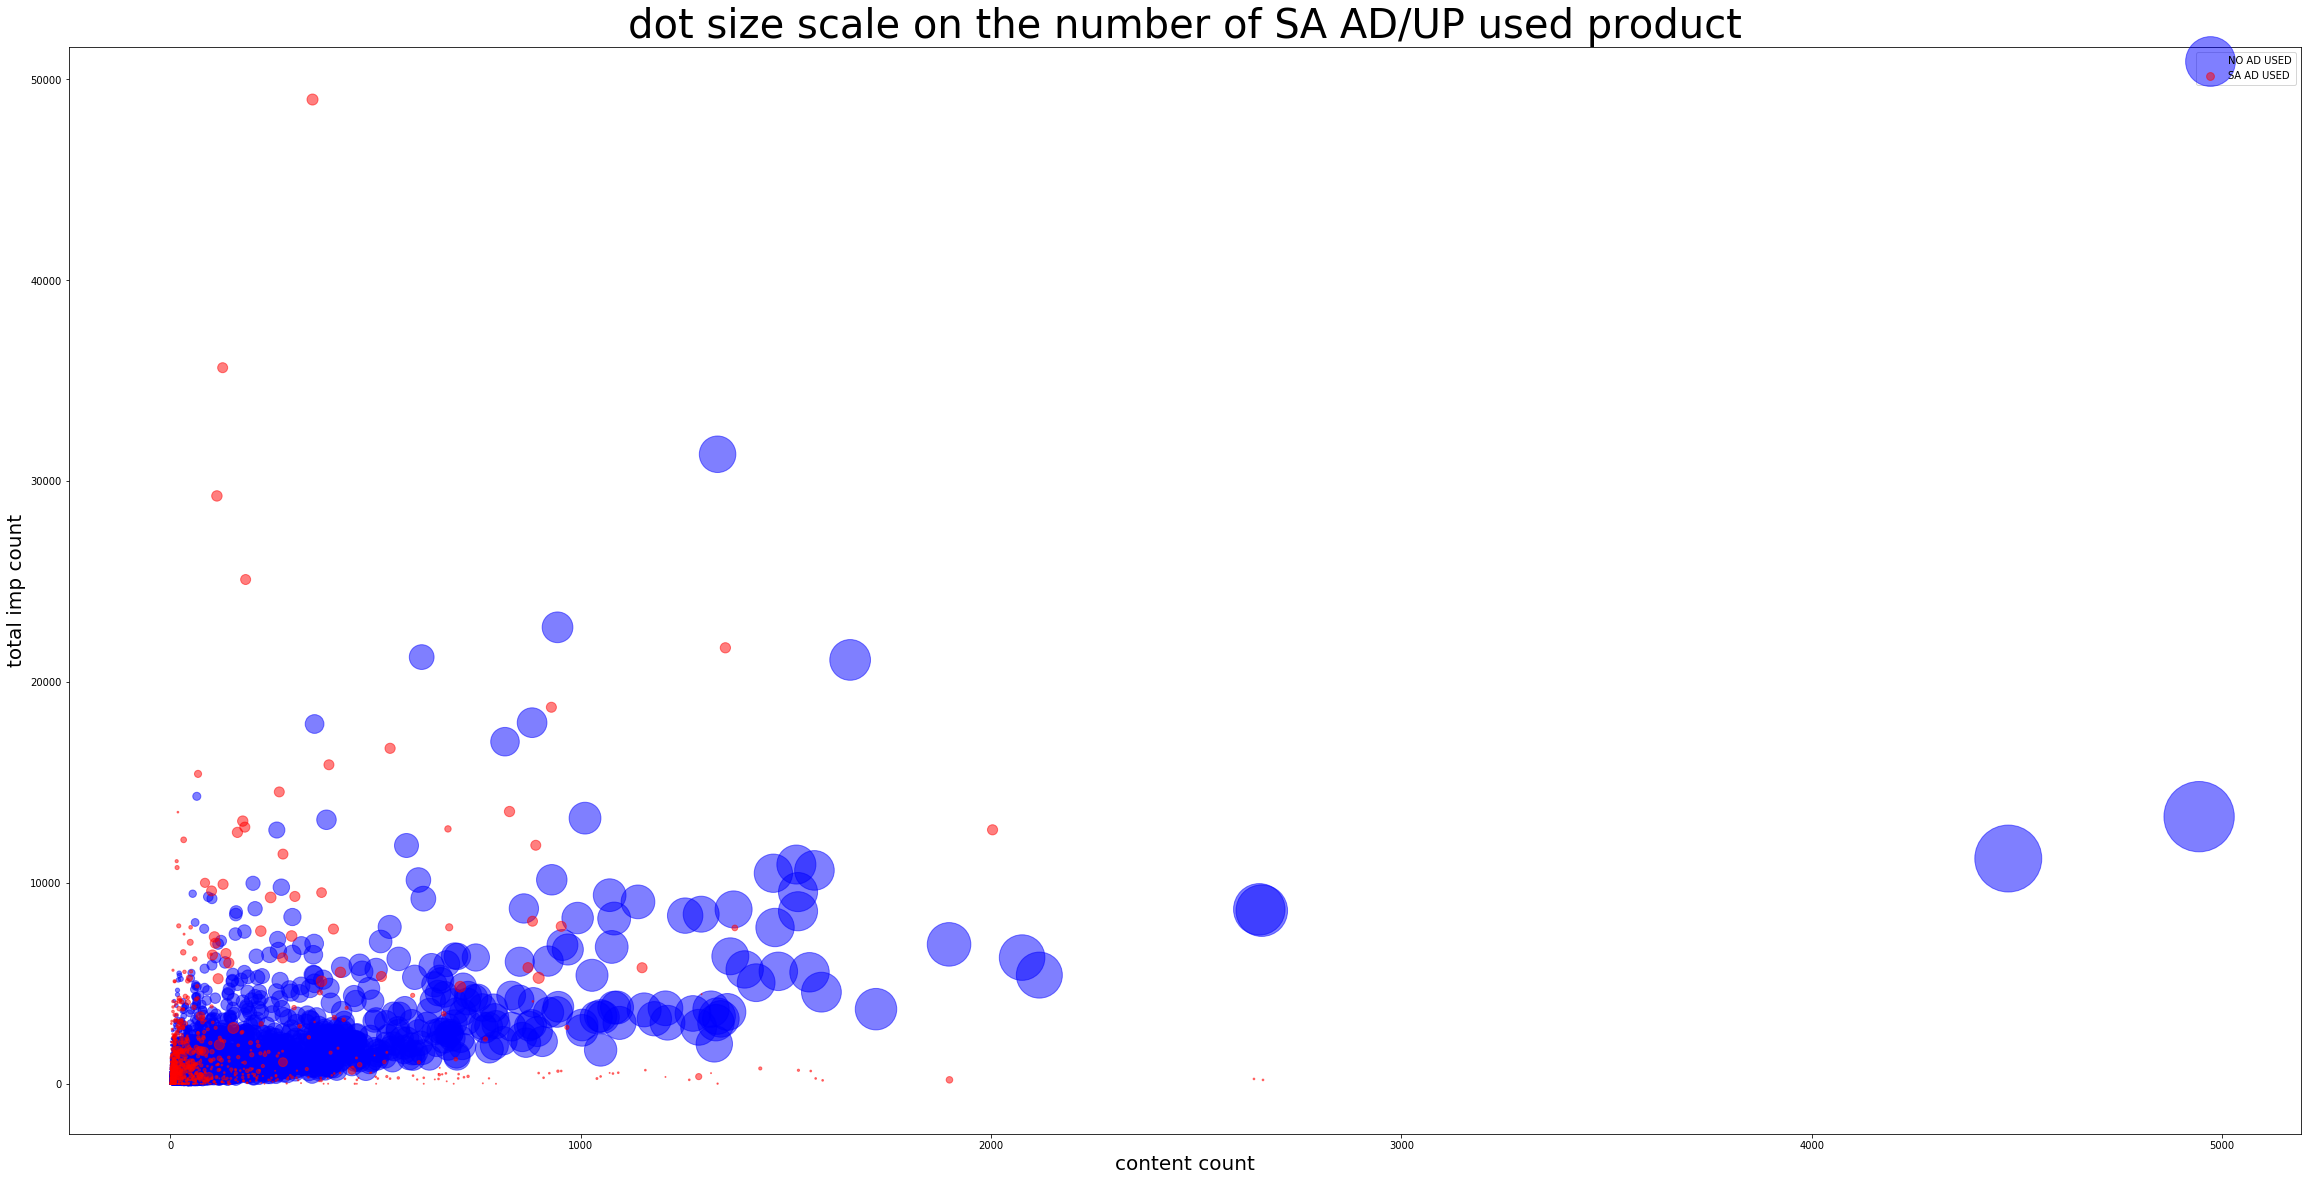

In [63]:
plt.figure(figsize=(40, 20))
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'up_pid_cnt', alpha= 0.5, color = 'blue', data=no_ad_user, label='NO AD USED')
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'ad_pid_cnt', alpha = 0.5, color = 'red', data=ad_user, label = 'SA AD USED')
plt.legend()

plt.xlabel('content count', fontsize=20)
plt.ylabel('total imp count', fontsize=20)
plt.title('dot size scale on the number of SA AD/UP used product', fontsize=40)

In [12]:
ad_user = pd.merge(ad_user, buntalk, on='content_owner')
no_ad_user = pd.merge(no_ad_user, buntalk, on='content_owner')

Text(0.5, 1.0, 'dot size scale on the number of buntalk received')

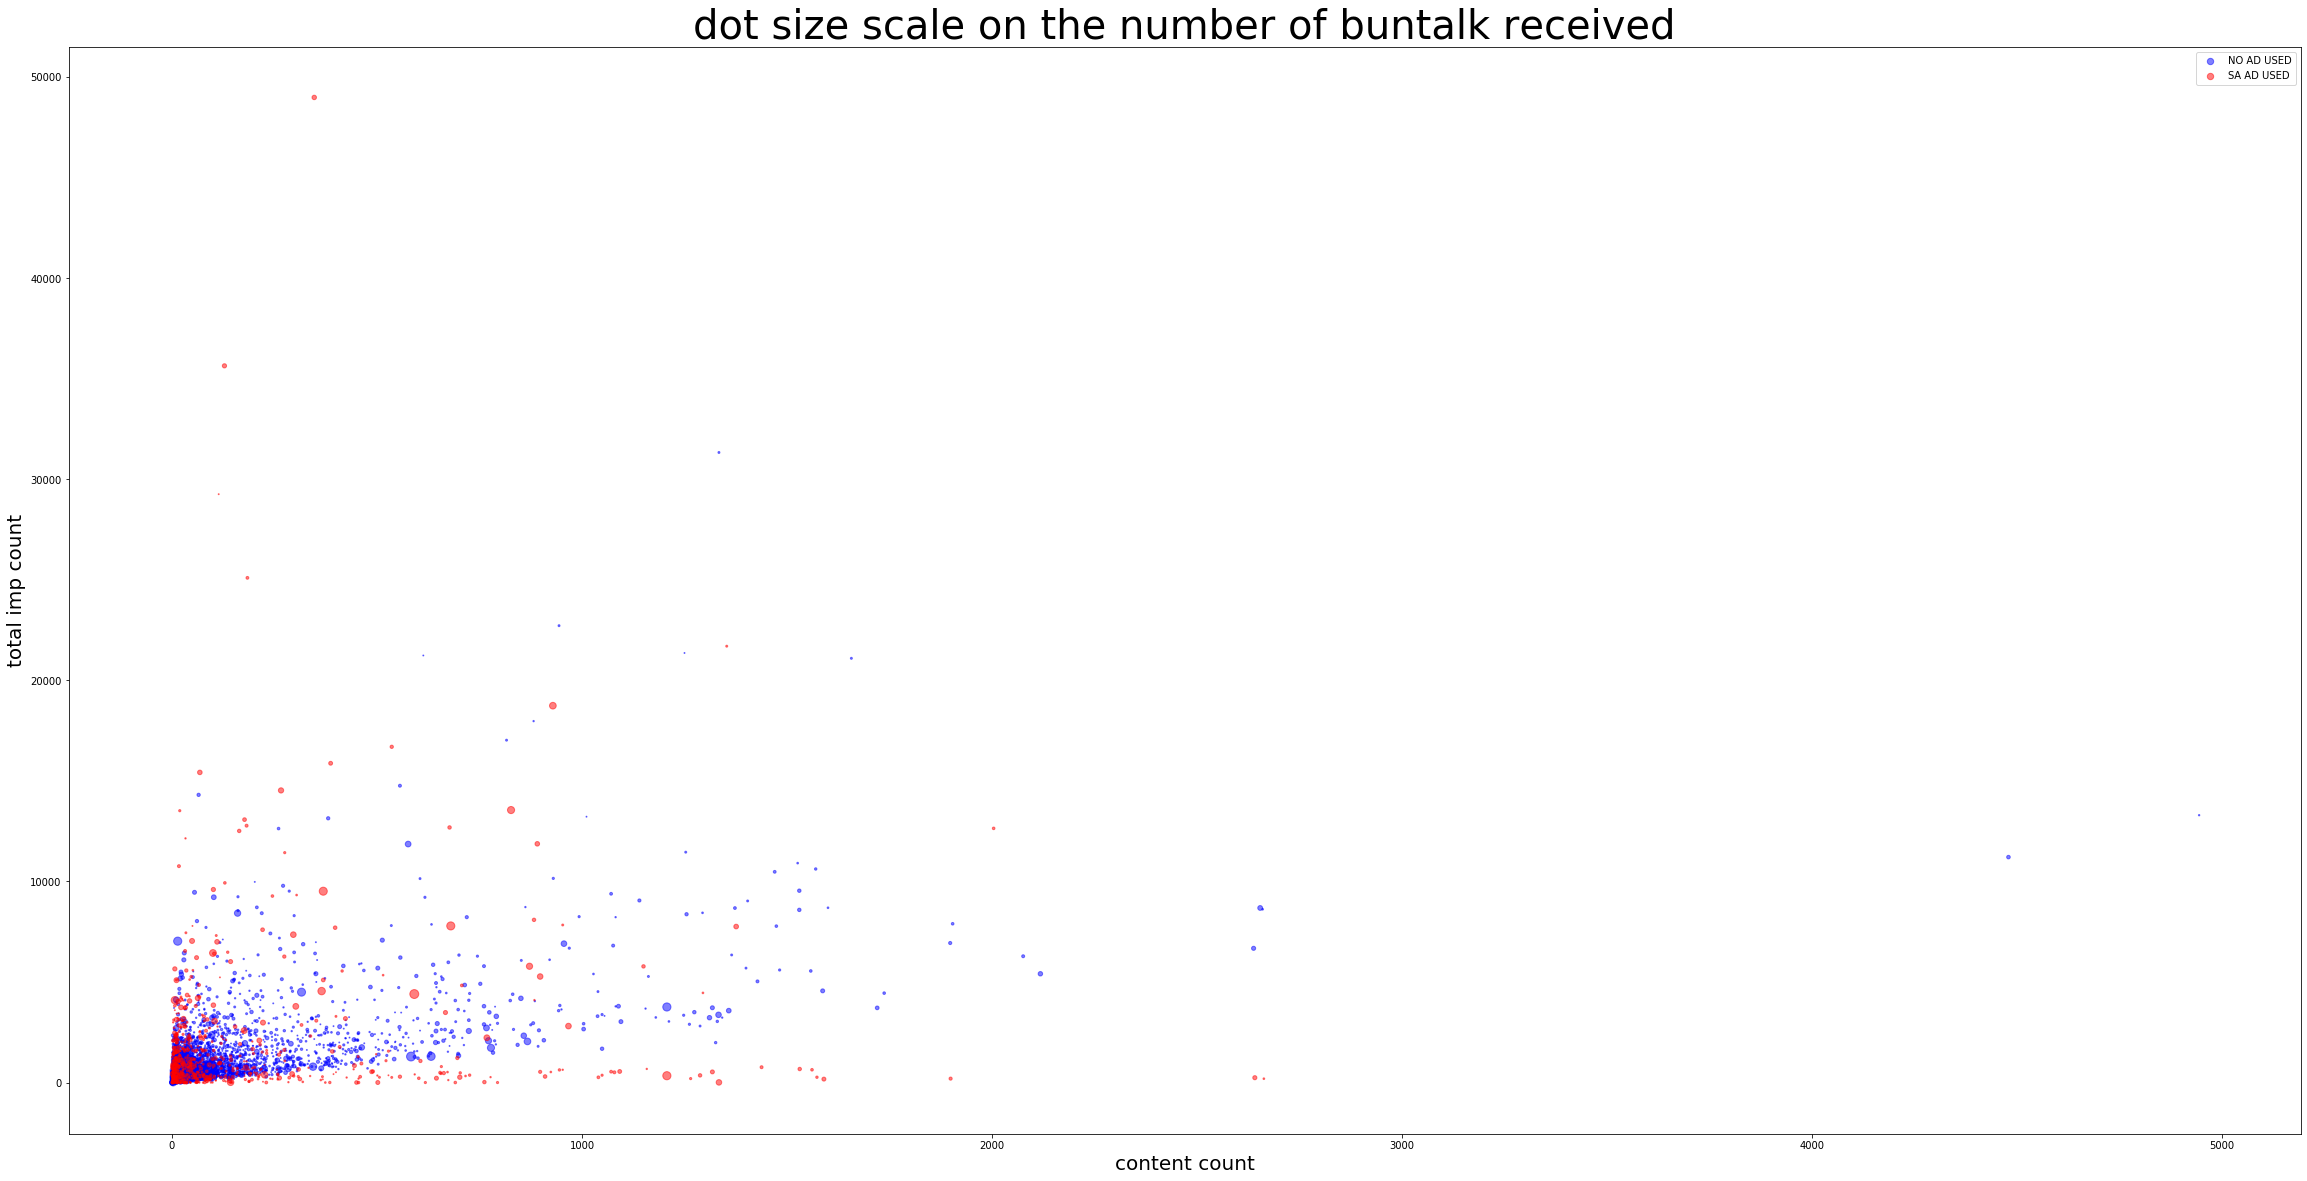

In [73]:
plt.figure(figsize=(40, 20))
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'buntalk_uid_cnt', alpha= 0.5, color = 'blue', data=no_ad_user, label='NO AD USED')
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'buntalk_uid_cnt', alpha = 0.5, color = 'red', data=ad_user, label = 'SA AD USED')
plt.legend()

plt.xlabel('content count', fontsize=20)
plt.ylabel('total imp count', fontsize=20)
plt.title('dot size scale on the number of buntalk received', fontsize=40)

Text(0.5, 1.0, 'dot size scale on the number of buntalk received')

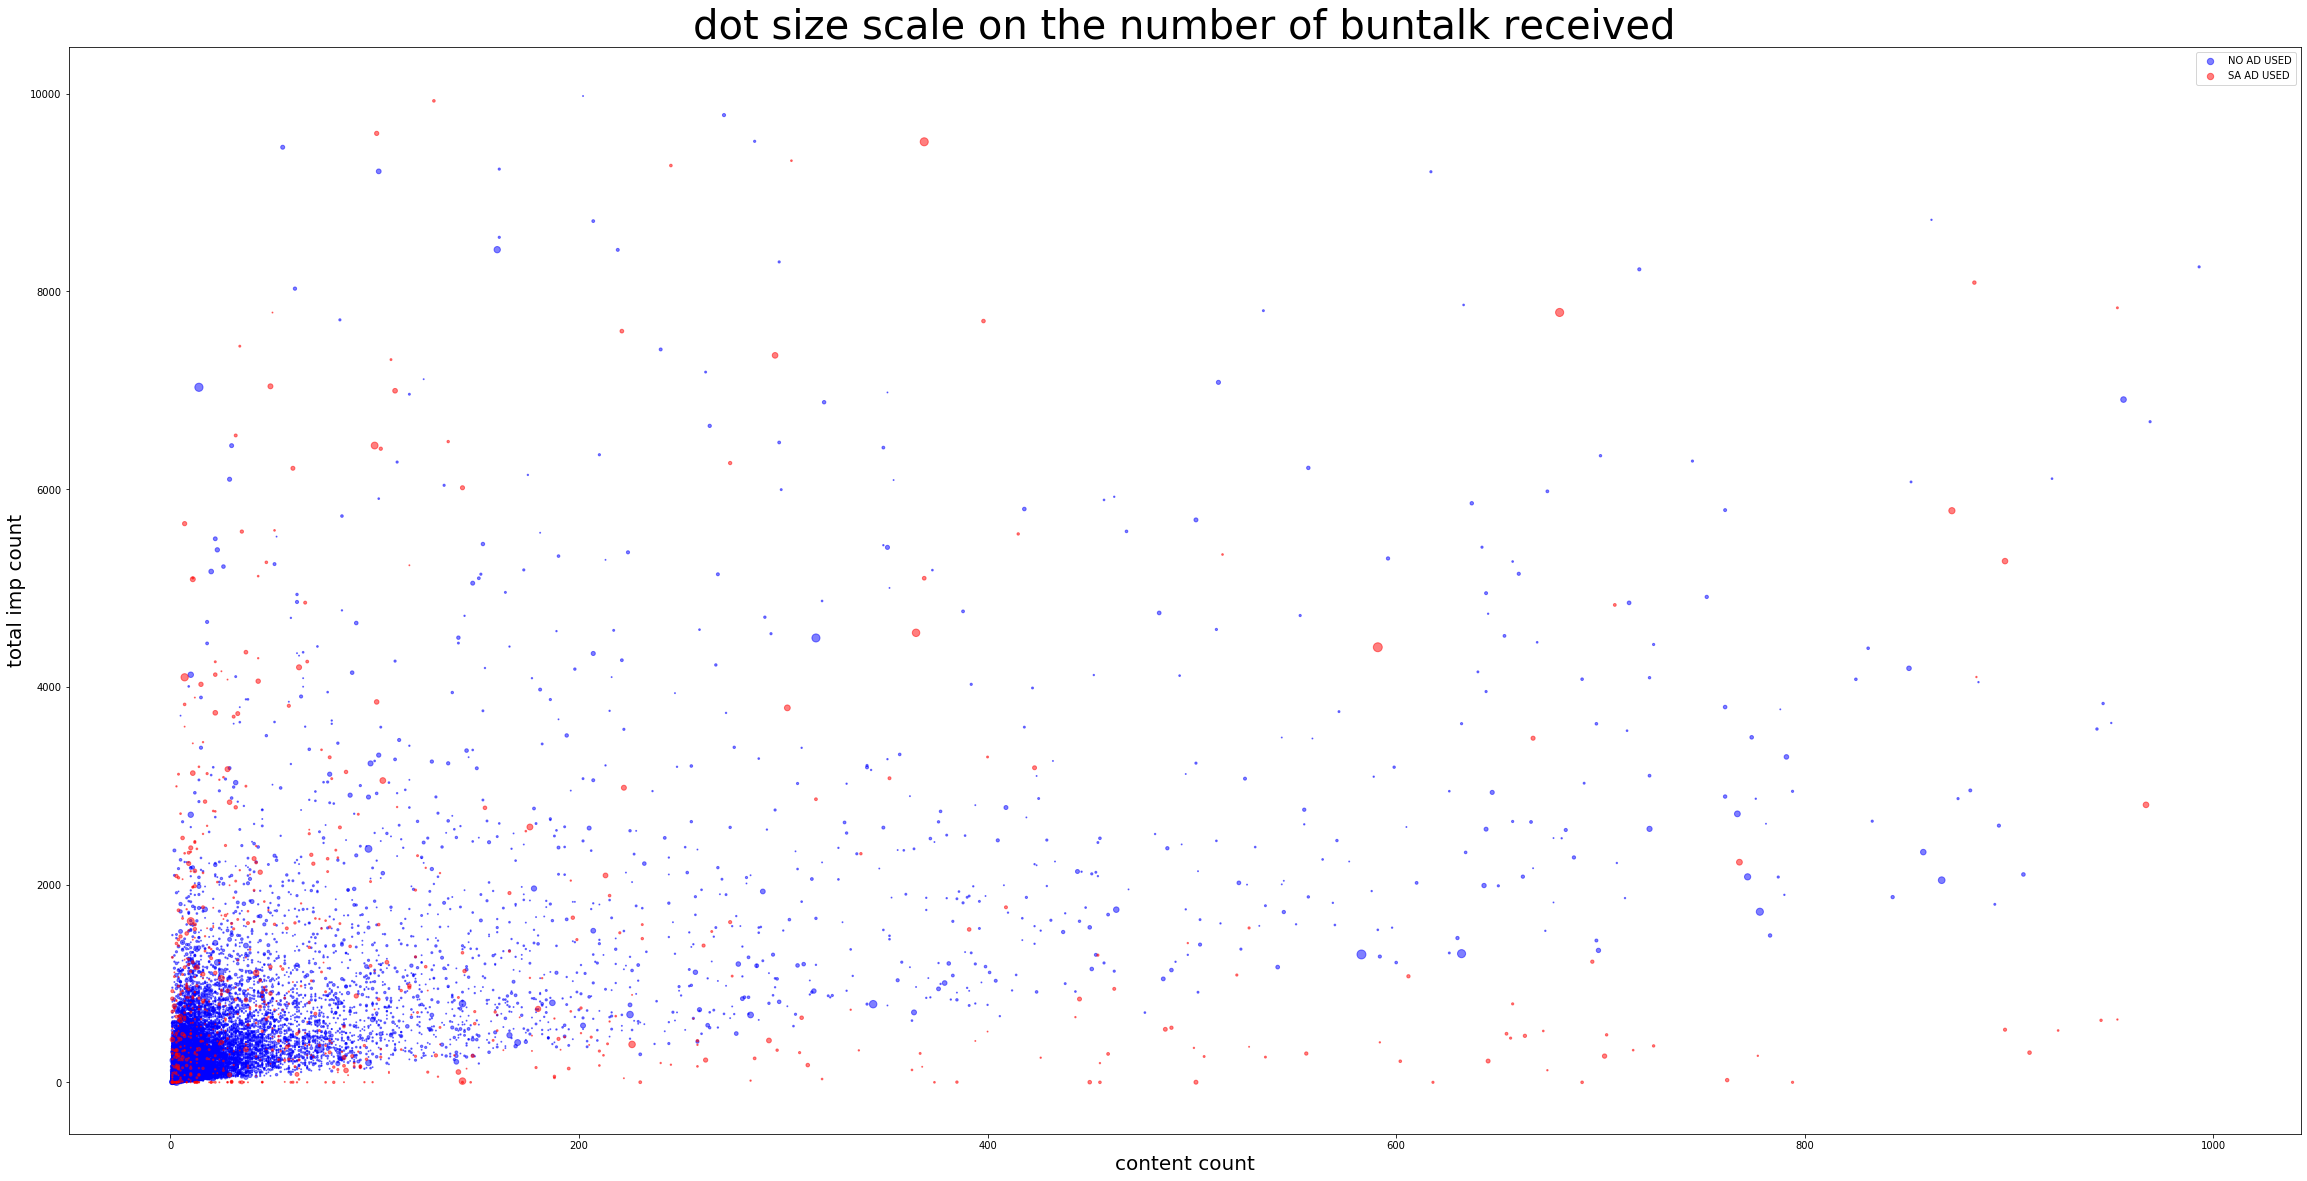

In [74]:
plt.figure(figsize=(40, 20))
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'buntalk_uid_cnt', alpha= 0.5, color = 'blue', data=no_ad_user[(no_ad_user['imp_cnt'] < 10000) & (no_ad_user['total_unique_pid_cnt'] < 1000)], label='NO AD USED')
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'buntalk_uid_cnt', alpha = 0.5, color = 'red', data=ad_user[(ad_user['imp_cnt'] < 10000) & (ad_user['total_unique_pid_cnt'] < 1000)], label = 'SA AD USED')
plt.legend()

plt.xlabel('content count', fontsize=20)
plt.ylabel('total imp count', fontsize=20)
plt.title('dot size scale on the number of buntalk received', fontsize=40)

In [101]:
temp_ad = imp_df[imp_df['content_owner'].isin(ad_user['content_owner'].unique())].groupby('content_owner', as_index=False)['rank_reverse'].sum()
temp_no_ad = imp_df[imp_df['content_owner'].isin(no_ad_user['content_owner'].unique())].groupby('content_owner', as_index=False)['rank_reverse'].sum()

In [102]:
import numpy as np

temp_ad.columns = ['content_owner', 'rank_sum']
temp_no_ad.columns = ['content_owner', 'rank_sum']

# temp_ad['rank_sum'] = np.log(temp_ad['rank_sum'])
# temp_no_ad['rank_sum'] = np.log(temp_no_ad['rank_sum'])

In [103]:
temp_ad['content_owner'] = temp_ad['content_owner'].astype(str)
temp_no_ad['content_owner'] = temp_no_ad['content_owner'].astype(str)

In [104]:
ad_user_2 = pd.merge(ad_user, temp_ad, on='content_owner')
no_ad_user_2 = pd.merge(no_ad_user, temp_no_ad, on='content_owner')

In [ ]:
plt.figure(figsize=(40, 20))
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'rank_sum', alpha= 0.5, color = 'blue', data=no_ad_user_2, label='NO AD USED')
plt.scatter('total_unique_pid_cnt', 'imp_cnt', s = 'rank_sum', alpha = 0.5, color = 'red', data=ad_user_2, label = 'SA AD USED')
plt.legend()

plt.xlabel('content count', fontsize=20)
plt.ylabel('total imp count', fontsize=20)
plt.title('dot size scale on the number of buntalk received', fontsize=40)

Text(0.5, 1.0, 'dot size scale on the number of buntalk received')